# Filtro de Kalman. Estimación de la trayectoria de un vehículo.

Se desea estimar la trayectoria de un vehı́culo, es decir la posición, velocidad y aceleración del mismo. Se cuenta con los datos reales de un vehı́culo, en los archivos .dat. Estos son los datos contra los cuales se comparará la estimación que obtengan al aplicar el FK. Lo primero que hay que hacer es generar las mediciones que serı́an la entrada al filtro de Kalman, estas mediciones se deberán generar de la siguiente manera:
Desde el punto 1 al 5 se supone que se mide en forma periódica (1seg) los siguientes datos.

## Implementación

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Carga de datos

Nota: no se subieron los archivos de datos al github.

In [3]:
pos_readings =  pd.read_csv("data/posicion.dat",header = None, delim_whitespace=True)
pos_readings.head()

,0,1,2,3
0,0.0,0.000000,0.000000,0.000000
1,1.0,-2.504231,-15.694906,39.450869
2,2.0,-10.103812,-28.431511,83.470978
3,3.0,-22.212787,-38.644100,131.710029
4,4.0,-38.245201,-46.766958,183.817725


In [4]:
vel_readings =  pd.read_csv("data/velocidad.dat",header = None, delim_whitespace=True)
vel_readings.head()

,0,1,2,3
0,0.0,0.238761,-17.318819,37.049483
1,1.0,-5.149565,-14.143374,41.793872
2,2.0,-9.951937,-11.402216,46.187963
3,3.0,-14.168354,-9.095343,50.231756
4,4.0,-17.798816,-7.222756,53.925252


In [5]:
acc_readings =  pd.read_csv("data/aceleracion.dat",header = None, delim_whitespace=True)
acc_readings.head()

,0,1,2,3
0,0.0,-5.681304,3.392587,4.919538
1,1.0,-5.095349,2.958302,4.569240
2,2.0,-4.509394,2.524016,4.218942
3,3.0,-3.923440,2.089730,3.868644
4,4.0,-3.337485,1.655444,3.518346


In [6]:
num_rows = pos_readings.shape[0]
num_rows

351

In [7]:
assert(pos_readings.shape[0]==vel_readings.shape[0]==acc_readings.shape[0]==num_rows)

Se almacenan los datos de los tres sensores en la matriz *clean_measurements*. Luego se harán copias y aplicará ruido para los distintos ítems.

In [8]:
clean_measurements = np.hstack((
    pos_readings.values[:,1:4],
    vel_readings.values[:,1:4],
    acc_readings.values[:,1:4]
))

clean_measurements.shape

(351, 9)

### 2. Parámetros iniciales

NOTA: Hay que tener en cuenta que al inicializar el Kalman en general no se conoce exactamente cuál es la posición, velocidad y aceleración del vehı́culo sino que tienen una aproximación de estas con cierto error. Se tomará como condiciones iniciales:

In [9]:
SAMPLING_RATE = 1 # 1Hz

In [10]:
x0 = np.array([10.7533, 36.6777, -45.1769, 1.1009, -17.0, 35.7418, -5.7247, 3.4268, 5.2774]).reshape(9,1)
x0

array([[ 10.7533],
       [ 36.6777],
       [-45.1769],
       [  1.1009],
       [-17.    ],
       [ 35.7418],
       [ -5.7247],
       [  3.4268],
       [  5.2774]])

In [11]:
p0 = np.diag([100, 100, 100, 1, 1, 1, 0.01, 0.01, 0.01])
p0.shape

(9, 9)

### 3. Simulaciones


$$
X_{t+1} = AX_t+ \xi_t
$$

$$
Y_{t} = CX_t+ \eta_t
$$

$$
A = 
\begin{bmatrix}
1 && 0 && 0  &&  h  && 0   && 0  &&  \frac{h^2}{2} && 0 && 0 \\
0 && 1 && 0  &&  0  &&  h  &&  0 &&   0        &&  \frac{h^2}{2} &&  0 \\
0 && 0 && 1  &&   0  &&  0 &&  h &&   0        &&         0 &&  \frac{h^2}{2} \\   
0 && 0 && 0  &&   1  &&  0 &&  0 &&   h &&  0 &&  0 \\
0 && 0 && 0  &&   0  &&  1 &&  0 &&   0 &&  h &&  0 \\
0 && 0 && 0  &&   0  &&  0 &&  1 &&   0 &&  0 &&  h \\        
0 && 0 && 0  &&   0 &&  0 &&  0 &&   1 &&  0 &&  0 \\
0 && 0 && 0  &&   0 &&  0 &&  0 &&   0 &&  1 &&  0 \\
0 && 0 && 0  &&   0 &&  0 &&  0 &&   0 &&  0 &&  1 \\
\end{bmatrix}
$$

In [12]:
def run_kalman(x0,p0,H,R, measurements):    
    """
        x0: estado inicial
        p0: matriz de covarianza inicial
        H: 
    """
    # Inicialización
    x = x0                
    n = x.shape[0]
    
    #Matrix de covarianza
    P = p0        
    
    # dt constante (1 muestra por segundo)
    h = 1/SAMPLING_RATE # en segundos
    
    # Matriz de trancisión de estado
    A = np.array([
        [ 1, 0, 0,  h, 0, 0,  (h**2)/2,        0, 0        ],
        [ 0, 1, 0,  0, h, 0,  0       , (h**2)/2, 0        ],
        [ 0, 0, 1,  0, 0, h,  0       ,        0, (h**2)/2 ],
    
        [ 0, 0, 0,  1, 0, 0,  h, 0, 0 ],
        [ 0, 0, 0,  0, 1, 0,  0, h, 0 ],
        [ 0, 0, 0,  0, 0, 1,  0, 0, h ],
        
        [ 0, 0, 0,  0, 0, 0,  1, 0, 0 ],
        [ 0, 0, 0,  0, 0, 0,  0, 1, 0 ],
        [ 0, 0, 0,  0, 0, 0,  0, 0, 1 ]
    ]) 

    I = np.eye(9)
    
    results = []    
    # Puedo recibir sz=3 (pos) o sz=6 (pos+vel)
    measurement_sz = measurements.shape[1]
    for z in measurements:
        Z = z.reshape(1,measurement_sz)
    
        # Paso 1. Predicción    
        x = A@x
        P = (A@P)@A.T
    
        #P[0,0] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[1,1] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[2,2] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[3,3] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[4,4] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[5,5] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[6,6] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[7,7] +=  0.1 # Ver, agregar ruido del proceso acá?
        #P[8,8] +=  0.1 # Ver, agregar ruido del proceso acá?
    
        # Paso 2. Medir y actualizar
        y = Z.T - H@x
        
        # Ganancia Kalman
        S = ((H@P)@H.T) + R
        K = (P@H.T)*np.linalg.inv(S)
        
        # El próximo X c/ contribución de las mediciones
        x = x + (K@y)        
        
        # FIXME. Acá estoy haciendo algo mal. 
        # Revisar dimensiones, no debería ser necesario el [:,0].
        x = x[:,0] 
        P = (I - K@H)@P    
        results.append(x)

    return np.array(results)

In [13]:
def plot_results(simulation_values,measurements,title="Filtro Kalman"):
    t = np.arange(0,measurements.shape[0])
    fig, axs = plt.subplots(3,3,figsize=(16,8))
    fig.suptitle(title)
    titles = [
        "$p_x$","$p_y$","$p_z$",
        "$v_x$","$v_y$","$v_z$",
        "$a_x$","$a_y$","$a_z$"
    ]
    for i in range(9):    
        iy = int(i/3)
        ix = int(i%3)
        axs[iy][ix].set_title(titles[i])
        axs[iy][ix].grid(which="Both")
        
        axs[iy][ix].plot(t,measurements[:,i], '.',markersize=2)
        axs[iy][ix].plot(t,simulation_values[:,i],'-g')
        axs[iy][ix].legend(["Medición","Predicción"])    

### 3.1 Simulación 1

1. Se mide la posición afectada por ruido blanco (gaussiano) de 10m de desvı́o estándar. Es decir que se le debe agregar ruido blanco con una distribución gaussiana con media cero y desvı́o 10.

In [14]:
noise = np.random.normal(loc=0,scale=10,size=(num_rows,3))
measurements = clean_measurements.copy()[:,0:3] + noise

In [15]:
# Se usa sólo la posición
H = np.matrix([
    [1., 0., 0.,  0.,0.,0.,  0., 0.,0. ],
    [0., 1., 0.,  0.,0.,0.,  0., 0.,0. ], 
    [0., 0., 1.,  0.,0.,0.,  0., 0.,0. ]
])

# Incerteza en la medición. confirmar unidad
R = np.matrix([
    [10., 0., 0.],
    [0., 10., 0.], 
    [0., 0., 10.]
])

In [16]:
results = run_kalman(x0,p0,H,R, measurements)

#### Resultado

Nota: provisoriamente se compara contra las mediciones limpias, pero debe ser contra los datos reales de posición, velocidad y aceleración del avión(no las mediciones).

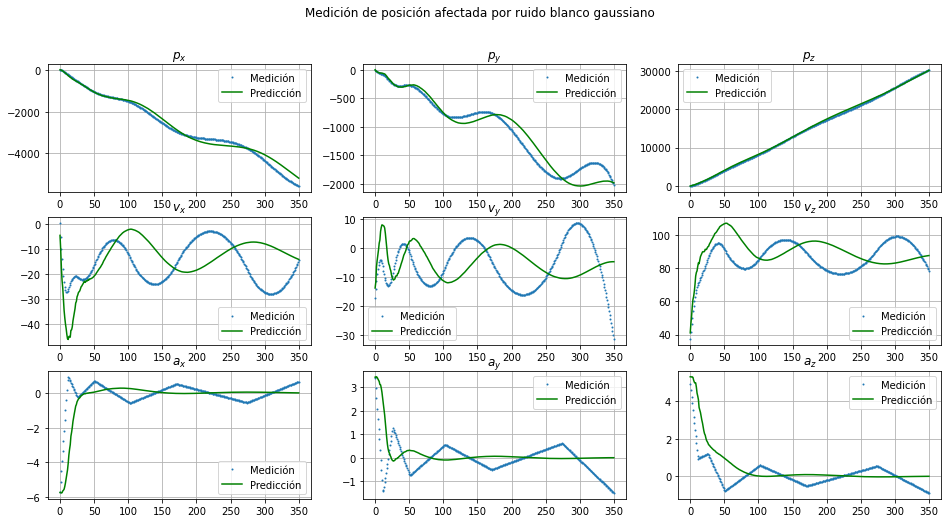

In [17]:
plot_results(results,clean_measurements, title="Medición de posición afectada por ruido blanco gaussiano")    

### 3.2 Simulación 2

2. Se mide la posición afectada por ruido blanco (uniforme) de 10m de desvı́o estándar. Similar al ı́tem anterior. La idea es comparar con el ı́tem anterior. Analizar si hubo algún cambio.

In [18]:
noise = np.random.uniform(low=-5.0,high=5.0,size=(num_rows,3))
measurements = clean_measurements.copy()[:,0:3] + noise

In [19]:
# Se usa sólo la posición
H = np.matrix([
    [1., 0., 0.,  0.,0.,0.,  0., 0.,0. ],
    [0., 1., 0.,  0.,0.,0.,  0., 0.,0. ], 
    [0., 0., 1.,  0.,0.,0.,  0., 0.,0. ]
])

# Incerteza en la medición. ver unidad
R = np.matrix([
    [10., 0., 0.],
    [0., 10., 0.], 
    [0., 0., 10.]
])

In [20]:
results = run_kalman(x0,p0,H,R,measurements)

#### Resultado

Nota: provisoriamente se compara contra las mediciones limpias, pero debe ser contra los datos reales de posición, velocidad y aceleración del avión(no las mediciones).

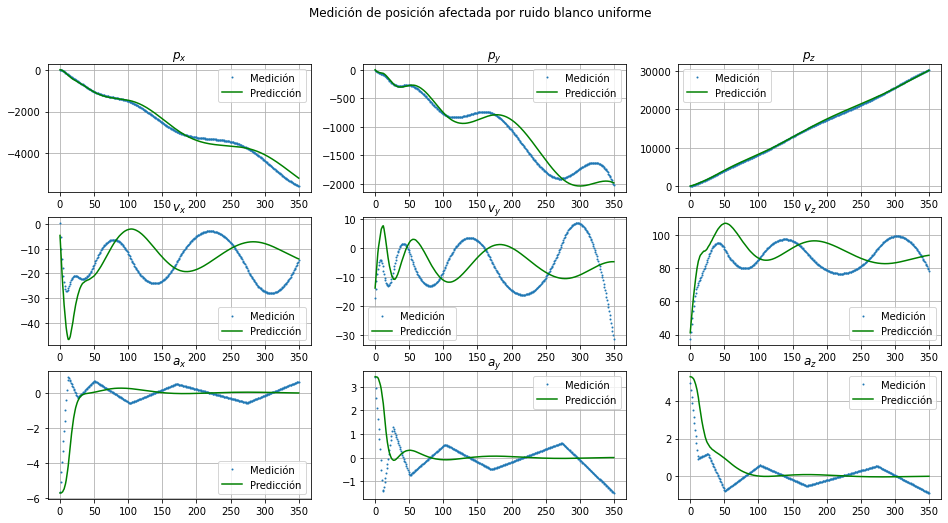

In [21]:
plot_results(results,clean_measurements, title="Medición de posición afectada por ruido blanco uniforme") 

### 3.3 Simulación 3

3. Se mide la posición y la velocidad afectadas por ruido blanco (gaussiano) de 10m y 0.2m/s de desvı́os respectivamente. Analizar si mejora la estimación.

In [22]:
pos_noise = np.random.normal(loc=0.0,scale=10,size=(num_rows,3))
vel_noise = np.random.normal(loc=0.0,scale=0.2,size=(num_rows,3))
measurements = clean_measurements.copy()[:,0:6]

measurements[:,0:3] +=  pos_noise
measurements[:,3:6] +=  vel_noise

In [23]:
# Se usa posición y velocidad
H = np.matrix([
    [1., 0., 0.,  0.,0.,0.,  0., 0.,0. ],
    [0., 1., 0.,  0.,0.,0.,  0., 0.,0. ], 
    [0., 0., 1.,  0.,0.,0.,  0., 0.,0. ],
    
    [0., 0., 0.,  1.,0.,0.,  0., 0.,0. ],
    [0., 0., 0.,  0.,1.,0.,  0., 0.,0. ], 
    [0., 0., 0.,  0.,0.,1.,  0., 0.,0. ]
])

# Incerteza en la medición. ver unidad
R = np.matrix([
    [10., 0., 0., 0., 0., 0., ],
    [0., 10., 0., 0., 0., 0., ],
    [0., 0., 10., 0., 0., 0., ],
    [0., 0., 0., 0.2, 0., 0., ],
    [0., 0., 0., 0., 0.2, 0., ],
    [0., 0., 10., 0., 0., 0.2 ],
])

In [24]:
results = run_kalman(x0,p0,H,R,measurements)

#### Resultado

Nota: provisoriamente se compara contra las mediciones limpias, pero debe ser contra los datos reales de posición, velocidad y aceleración del avión(no las mediciones).

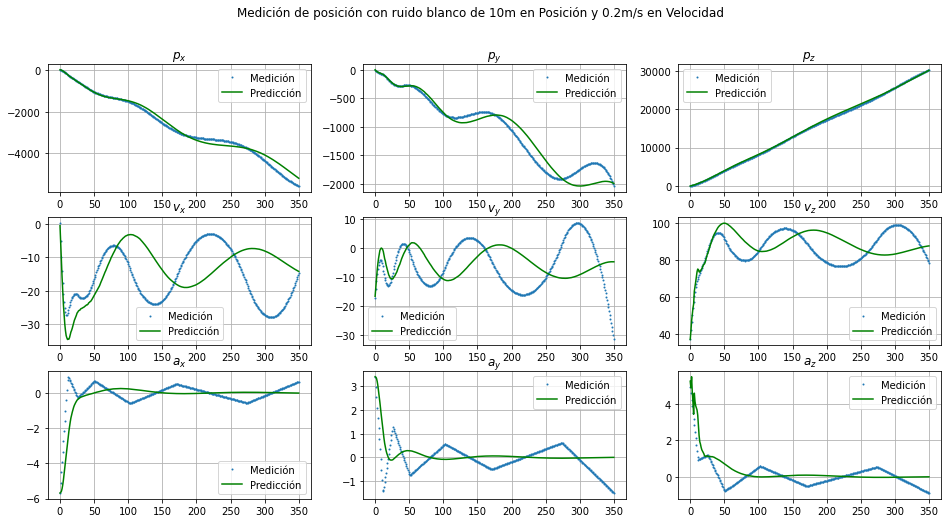

In [25]:
plot_results(results,clean_measurements, title="Medición de posición con ruido blanco de 10m en Posición y 0.2m/s en Velocidad") 